# Introduction

## Hindsight-Experience-Replay (HER)

A challanging problem in reinforcement learning is finding a policy under insufficient 
exploration strategies. In sparse reward settings, policy gradient methods usually fail when 
it's barely possible to reach the target state by random exploration, so they'd never see a encouraging reward signal. 
This is the usual setting in a lot of robotics tasks, where there is a huge (+continuous) statespace to explore.  
The usual approach is designing a task-specific rich reward signal, which leads the policy to the goal. However, this 
setting requires domain knowlegde and a carefully shaped reward, to not converge to suboptimal policies for the task. 
[HER - Andrychowicz et al., 2017](https://arxiv.org/abs/1707.01495) introduced an alternative approach, which could be seen as an augmented generic reward, that helps 
learning environment dynamics even without ever seeing an encouraging reward from the task itself. 
  
In the HER setting, the agent observes a defined goalstate together with it's current state in the environment. This makes it easy  
to switch goals on the fly with the agents awareness (compared to i.e. random goals in a maze setting). How does it help? 
While the original task-goalstate may be difficult to reach, the agent is still exploring other states(, but never seeing a positive reward).
HER is rewarding the agent for reaching those "other states". This is done by replaying a given episode with the "other state" as goal input and a positive 
reward when reaching those "other state". Intuitively this teaches the agent how to navigate in the environment to reach given goal states, and hopefully generalize to 
new unseen goalstates.





# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd #for plotting 
#from numpy_net import numpy_net as nn #newer version of mlp_framework(+conv layers) but different repo: https://github.com/monoelh/numpy-net
import mlp_framework as nn
import ddqn_framework as DF # using the replaybuffer and bellman updates

# Bitflip game

In section **_3.1_** of the HER paper a bit-flipping is used to demonstrate the unique advantage of HER compared to vanilla DQN and/or other exploration techniques.  
Given a random string of n bits and a goalstring of n bits, the agent can flip a single bit each turn. Input space is [current_state, goal_state]. The agent gets a reward of '-1' for each action. when reaching the goal it receives a reward of '0'. For longer strings, statespace simply becomes to big to exlore a suffcient amount of states, so exploration based methods won't help.

In [2]:
### binary string copy game
class nbit_flip:
    
    def __init__(self,stringlength=8,goal=[]):
        self.goalstring = np.random.choice([0,1],stringlength)
        self.startstring = np.random.choice([0,1],stringlength)
        while (self.startstring == self.goalstring).all():
            self.startstring = np.random.choice([0,1],stringlength)
        self.statestring = self.startstring      
        
    def random_action(self):
        return np.random.randint(0,self.goalstring.shape[0])
    
    def reset(self):
        self.goalstring = np.random.choice([0,1],self.goalstring.shape[0])
        self.startstring = np.random.choice([0,1],self.goalstring.shape[0])
        while (self.startstring == self.goalstring).all():
            self.startstring = np.random.choice([0,1],self.goalstring.shape[0])
        self.statestring = self.startstring       
        return np.concatenate((self.statestring,self.goalstring))
    
    def step(self,action):
        self.statestring[action] = np.logical_not(self.statestring[action]).astype(int)
        if (self.statestring == self.goalstring).all():            
            done = True
            reward = 0
        else: 
            done = False
            reward = -1  
        return np.concatenate((self.statestring,self.goalstring)), reward, done
        

# (D)DQN

In the paper a DQN with a single hidden layer, containing 256 neurons is used to demonstrate the advantge of HER. Without HER DQN fails for binary strings >13, while HER is able to solve strings with "up to 50" bits.  
Here, a Double DQN (van Hasselt 2015) is used to stabilize training. If targetNet = onlineNet it boils down to DQN.

In [3]:
bits = 20  # number of bit for bitflipping game

A1 = nn.layer(bits*2,256)
A1.f = nn.f_relu
AOUT = nn.layer(256,bits)
AOUT.f = nn.f_iden

L1 = nn.layer(bits*2,256)
L1.f = nn.f_relu
LOUT = nn.layer(256,bits)
LOUT.f = nn.f_iden

onlineNet = nn.mlp([A1,AOUT]) #if u r numpy_net instead of mlp_framework it's nn.module([...])
for L in onlineNet.Layerlist:
    try:
        L.eta = 1e-3
    except:
        pass
targetNet = nn.mlp([L1,LOUT]) #if u r numpy_net instead of mlp_framework it's nn.module([...])
for L in targetNet.Layerlist:
    try:
        L.eta = 1e-3
    except:
        pass


# Training 

The training procedure is seperated in 'epochs', 'cycles', 'episodes'. Each epoch consists of a number of cylces, after which the DQN is trained for a few iterations and the target network (DDQN) is updated. In each cycle, a number of episodes is played before training. The experience from an episode is temporarily stored, added to the raplaybuffer and then added again with a subtituted goal.  
Parameters are consistent with those mentioned in the paper, with the only difference beeing training for 5 instead of 200 epochs and updating the target network without decay. (and a smaller replaybuffer, which doesn't seem to downgrade performance in this setting). 
Set 'HER' variable to 'False' to diable hinsight experience replay.

In [4]:
HER = True ## toggle Hindsight Experience Replay

loss_plot = []
rew_plot = []

ringB = DF.ringbuffer(1e5)

MAX_EPOCHS = 6
MAX_CYCLES = 50
MAX_EPISODES = 16
MAX_STEPS = bits
UPDATE_STEPS = 40
EXPLORATION = 500

BATCHSIZE = 128
GAMMA = 0.98
E_MIN = 0.02


game = nbit_flip(bits)

step_count = 0
success_rate = []

for E in range(MAX_EPOCHS):
    
    #run cycle
    for c in range(MAX_CYCLES):
        successes = []
        
        #run episodes
        for e in range(MAX_EPISODES):
            eps_reward = 0
            episode_buffer = []
            current_state = game.reset()

            #run game
            for p in range(MAX_STEPS):
                e = 1. / (((step_count)/EXPLORATION)+1)

                if np.random.uniform(0,1) < max(E_MIN,e):
                    action = game.random_action()
                else:
                    action = np.argmax(onlineNet.infer(current_state[True,:]))

                next_state, reward, done = game.step(action)
                eps_reward += reward
                step_count += 1
                episode_buffer += [(current_state, action, reward, next_state,done)]
                current_state = next_state
                if done or (p+1)==MAX_STEPS: 
                    successes += [done]
                    rew_plot += [eps_reward]
                    break
            #run replay   
            for r in range(p):
                # add each episode step to RPB
                s = np.array(episode_buffer[r][0])
                a = np.array([episode_buffer[r][1]])
                rew = np.array([episode_buffer[r][2]])
                s_ = np.array(episode_buffer[r][3])
                d = np.array([episode_buffer[r][4]])
                ringB.add([s,a,rew,s_,d])
                
                #run hindsight experience replay
                if HER:
                    # take last state as goal and add (whole) episode to RPB
                    g = np.array(episode_buffer[p-1][3][:bits])
                    s = np.concatenate((s[:bits],g))
                    if (s_[:bits] == g).all(): 
                        rew = np.array([0])
                        d = np.array([True])
                    else:
                        rew = np.array([-1])
                        d = np.array([False])
                    s_ = np.concatenate((s_[:bits],g))
                    ringB.add([s,a,rew,s_,d])
                    
        if (c+1) % 10 == 0: print(np.mean(successes),' cycle success rate')
        success_rate += [np.mean(successes)]
        
        #run training
        if step_count > BATCHSIZE:
            for u in range(UPDATE_STEPS):
                BATCH = ringB.sample(BATCHSIZE)
                DF.train_bellman(onlineNet, targetNet, BATCH, GAMMA)
                loss_plot += [onlineNet.loss]
                
            #update target net
            DF.update_target(onlineNet,targetNet)
            
    print(np.mean(success_rate[-MAX_CYCLES:]),' epoch {}/{} success rate'.format(E+1,MAX_EPOCHS))

0.0  cycle success rate
0.0  cycle success rate
0.0  cycle success rate
0.0  cycle success rate
0.0  cycle success rate
0.0  epoch 1/6 success rate
0.0  cycle success rate
0.0  cycle success rate
0.0  cycle success rate
0.4375  cycle success rate
0.4375  cycle success rate
0.12875  epoch 2/6 success rate
0.6875  cycle success rate
0.625  cycle success rate
0.6875  cycle success rate
0.875  cycle success rate
0.875  cycle success rate
0.6175  epoch 3/6 success rate
0.9375  cycle success rate
0.9375  cycle success rate
0.8125  cycle success rate
0.9375  cycle success rate
0.875  cycle success rate
0.825  epoch 4/6 success rate
0.9375  cycle success rate
0.8125  cycle success rate
0.9375  cycle success rate
0.875  cycle success rate
1.0  cycle success rate
0.90625  epoch 5/6 success rate
1.0  cycle success rate
0.9375  cycle success rate
1.0  cycle success rate
0.875  cycle success rate
1.0  cycle success rate
0.9625  epoch 6/6 success rate


# Plotting results

<IPython.core.display.Javascript object>


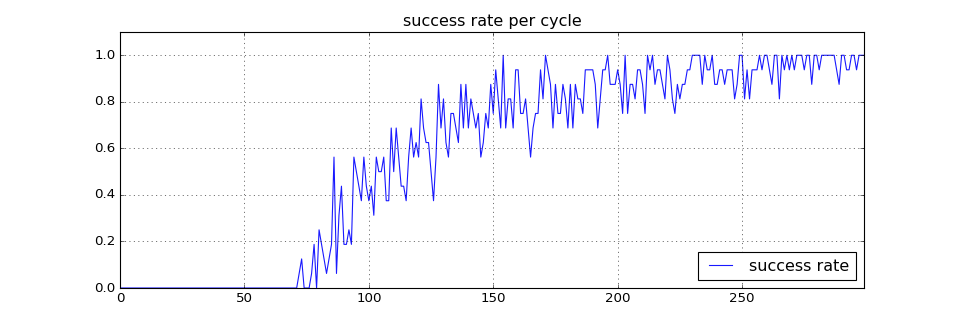

<IPython.core.display.Javascript object>


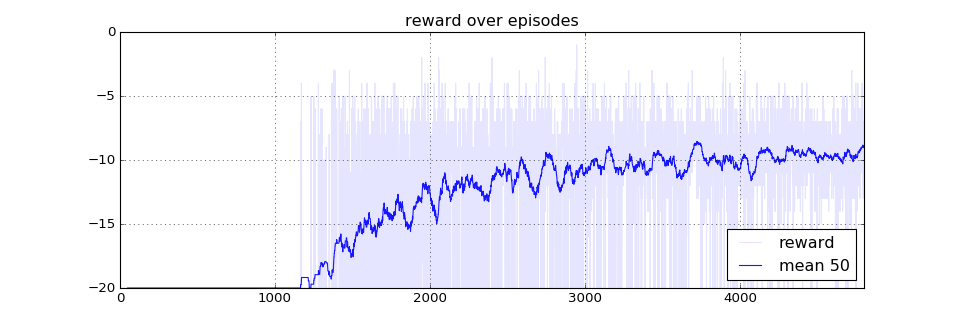

<IPython.core.display.Javascript object>


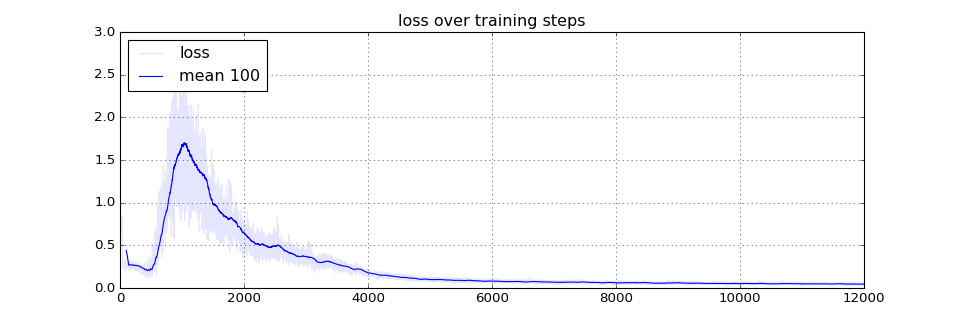

In [9]:
reward_plot = np.array(rew_plot) 
loss_plot = np.array(loss_plot) 
success_rate = np.array(success_rate)

succdata = pd.Series(success_rate)
rewdata = pd.Series(reward_plot)
lossdata = pd.Series(loss_plot)

plt.figure(figsize=(12,4))
succdata.plot(alpha=0.9,color='b',label='success rate')
plt.legend(loc='lower right')
plt.grid()
plt.ylim(0,1.1)
plt.title('success rate per cycle')

plt.figure(figsize=(12,4))
rewdata.plot(alpha=0.1,color='b',label='reward')
rewdata.rolling(window=50).mean().plot(style='b',alpha=.9,label='mean 50')
plt.legend(loc='lower right')
plt.grid()
plt.title('reward over episodes')

plt.figure(figsize=(12,4))
lossdata.plot(alpha=0.1,color='b',label='loss')
lossdata.rolling(window=100).mean().plot(style='b',label='mean 100')
plt.legend(loc='upper left')
plt.title('loss over training steps')
plt.grid()
plt.show()



# Let the Q-network play some games

In [8]:
newgame = nbit_flip(bits)
curr = newgame.reset()
s = 0 
print('NEW GAME')
print(newgame.goalstring, ' is the new goal -- start with: ',newgame.startstring)
for i in range(50):
    action = np.argmax(targetNet.infer(curr[True,:]))
    print('from {} flip bit nr. {}'.format(curr[:bits],action))
    curr, rew, d = newgame.step(action)
    s += 1
    if d or s == bits:
        if d: print('WON AFTER {} STEPS \n'.format(s))
        curr = newgame.reset()
        
        s = 0
        print('NEW GAME')
        print(newgame.goalstring, ' is the new goal -- start with: ',newgame.startstring)

NEW GAME
[1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1]  is the new goal -- start with:  [1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1]
from [1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1] flip bit nr. 4
from [1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1] flip bit nr. 11
from [1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1] flip bit nr. 1
from [1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1] flip bit nr. 6
from [1 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1] flip bit nr. 2
from [1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1] flip bit nr. 15
from [1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1] flip bit nr. 14
from [1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1] flip bit nr. 18
WON AFTER 8 STEPS 

NEW GAME
[1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1]  is the new goal -- start with:  [0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0]
from [0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0] flip bit nr. 0
from [1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0] flip bit nr. 19
from [1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1] flip bit nr. 2
from [1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0